<a href="https://colab.research.google.com/github/KushalPatil/Blockchain-authentitcation-simulation/blob/master/Housing_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

# Predicting Housing Prices in Ames, Iowa

The goal of this exercise to build a housing price predictor for the Ames, Iowa dataset. The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's a wonderful alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

## Part 1: Preliminary checks on file and loading the data

It's always good to do a few preliminary checks such as file size, line numbers, and printing the first few lines to not load corrupt data or exceed one's memory constraints.

In [2]:
from os import path
import warnings
warnings.filterwarnings("ignore")

iowa_file = '/content/train.csv'

In [3]:
print('File size in MB:')
print(path.getsize(iowa_file) / (1<<20))

File size in MB:
0.4393348693847656


In [4]:
print('Number of rows in file:')
with open(iowa_file) as file:
    print(sum(1 for line in file))

Number of rows in file:
1461


First few rows:

In [5]:
with open(iowa_file) as file:
    for lnum, line in enumerate(file):
        print(line)
        if lnum > 1:
            break

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice

1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PC

Looks good! Note that the data comes split into a train and a test portion. In practice, you'd need to run these tests on each portion but since this is a demonstration we proceed immediately with loading both files into memory.

In [6]:
import pandas as pd

iowa_train_data = pd.read_csv('/content/train.csv')
iowa_test_data = pd.read_csv('/content/train.csv')

In [7]:
print('Length of train data portion: {}\nLength of test data portion: {}'.format(len(iowa_train_data),
len(iowa_test_data)))

Length of train data portion: 1460
Length of test data portion: 1460


In [8]:
iowa_train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Part 2: Building a Random Forest model and handling missing values

First, we define the prediction features and target. For simplicity, we'll ignore categorical (non-numerical) data for now.

In [9]:
iowa_target = iowa_train_data['SalePrice']
iowa_predictors = iowa_train_data.drop(['SalePrice'], axis=1)

# For the sake of keeping the example simple, we'll use only numeric predictors. 
iowa_numeric_predictors = iowa_predictors.select_dtypes(exclude=['object'])

Let's also create a function to measure the quality of an approach. This function reports the out-of-sample mean absolute error (MAE) score from a Random Forest. We begin by splitting our training data into a a train and a test portion.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iowa_numeric_predictors, 
                                                    iowa_target,
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=0)

def score_dataset(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

We first try to handle missing values by dropping the entire column containing them and measure the resulting MAE.

In [11]:
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]
reduced_X_train = X_train.drop(cols_with_missing, axis = 1)
reduced_X_test  = X_test.drop(cols_with_missing, axis = 1)
print("Mean Absolute Error from dropping columns with missing values:")
print(int(score_dataset(reduced_X_train, reduced_X_test, y_train, y_test)))

Mean Absolute Error from dropping columns with missing values:
18003


We next try to replace missing values through standard imputation.

In [12]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
imputed_X_train = my_imputer.fit_transform(X_train)
imputed_X_test = my_imputer.transform(X_test)
print("Mean Absolute Error from imputation:")
print(int(score_dataset(imputed_X_train, imputed_X_test, y_train, y_test)))

Mean Absolute Error from imputation:
17868


Our error seems smaller but the improvement is so little that a different `random_state` could easily make the error bigger. Why haven't we improved? Let's look at how many missing values there actually are.

In [13]:
missing = X_train.isnull().sum()
missing[missing != 0]

LotFrontage    189
MasVnrArea       5
GarageYrBlt     54
dtype: int64

There are only few missing values (remember, there are 1460 rows) and they are concentrated in only 3 out of 80 features/columns. Replacing these with their mean values (which is what `SimpleImputer` does) is thus no improvement over simply dropping the three columns. Still, let's see if keeping track of which columns have missing values that are replaced improves the situation.

In [14]:
imputed_X_train_plus = X_train.copy()
imputed_X_test_plus = X_test.copy()

cols_with_missing = (col for col in X_train.columns if X_train[col].isnull().any())
for col in cols_with_missing:
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull()
    imputed_X_test_plus[col + '_was_missing'] = imputed_X_test_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = my_imputer.fit_transform(imputed_X_train_plus)
imputed_X_test_plus = my_imputer.transform(imputed_X_test_plus)

print("Mean Absolute Error from imputation while tracking what was imputed:")
print(int(score_dataset(imputed_X_train_plus, imputed_X_test_plus, y_train, y_test)))

Mean Absolute Error from imputation while tracking what was imputed:
17859


It does not. Again, the `random_state` variance is greater than the error difference.

## Part 3: Converting categorical data to dummy variables

Let's see if we can improve our model by one-hot encoding our categoricals, i.e. turning them into dummy variables.

In [15]:
one_hot_encoded_iowa_predictors = pd.get_dummies(iowa_predictors)

In [16]:
X_train_1hot, X_test_1hot, y_train, y_test = train_test_split(one_hot_encoded_iowa_predictors, 
                                                    iowa_target,
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=0)

cols_with_missing = [col for col in X_train_1hot.columns if X_train_1hot[col].isnull().any()]
reduced_X_train_1hot = X_train_1hot.drop(cols_with_missing, axis = 1)
reduced_X_test_1hot  = X_test_1hot.drop(cols_with_missing, axis = 1)

In [17]:
print("Mean Absolute Error from including categorical data:")
print(int(score_dataset(reduced_X_train_1hot, reduced_X_test_1hot, y_train, y_test)))

Mean Absolute Error from including categorical data:
17448


We have reduced the error by about $400. This should be more than the `random_state` variance and a first small piece of progress.

## Part 4: XGBoost

Let's use the powerful XGBoost regressor and run it on our data set with missing values dropped.

In [18]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

In [19]:
xgb.fit(reduced_X_train_1hot, y_train, verbose=False)

[16:11:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [20]:
xgb_preds = xgb.predict(reduced_X_test_1hot)
print("Mean Absolute Error: " + str(int(mean_absolute_error(y_test, xgb_preds))))

Mean Absolute Error: 16380


Great! We've reduced our error by another $1000. To further improve, let's find the optimal number of estimators to use in our XGBoost.

In [21]:
def get_xgb_mae(n_estimators, learning_rate=0.1):
    xgb = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
    xgb.fit(reduced_X_train_1hot, y_train, eval_set=[(reduced_X_test_1hot, y_test)], verbose=False)
    xgb_preds = xgb.predict(reduced_X_test_1hot)
    mae = mean_absolute_error(y_test, xgb_preds)
    print("Mean Absolute Error from using {} estimators at a learning rate of {}: {}"\
          .format(str(n_estimators), learning_rate, str(int(mae))))

In [22]:
for i in range(100, 1100, 100):
    get_xgb_mae(i)

[16:11:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error from using 100 estimators at a learning rate of 0.1: 16380
[16:11:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error from using 200 estimators at a learning rate of 0.1: 16028
[16:11:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error from using 300 estimators at a learning rate of 0.1: 15967
[16:11:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error from using 400 estimators at a learning rate of 0.1: 16014
[16:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error from using 500 estimators at 

We see that the best number of estimators is 300. By using a slower learning rate we may be able to further improve our results.

In [23]:
get_xgb_mae(300, 0.05)

[16:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error from using 300 estimators at a learning rate of 0.05: 15935


## Part 5: Training our model on the whole data set and submitting our work

Now that we have determined the best model and parameters, we train our model on the entire data set and submit our work.

In [24]:
# Starting data
iowa_target = iowa_train_data['SalePrice']
y_train = iowa_target
iowa_predictors = iowa_train_data.drop(['SalePrice'], axis=1)

# Drop missing values from training and test data
cols_with_missing = [col for col in iowa_predictors.columns if iowa_predictors[col].isnull().any()]
reduced_iowa_predictors = iowa_predictors.drop(cols_with_missing, axis = 1)
reduced_iowa_test_data = iowa_test_data.drop(cols_with_missing, axis = 1)

# Convert categoricals to dummies in training and test data and aligning the columns
one_hot_encoded_reduced_iowa_predictors = pd.get_dummies(reduced_iowa_predictors)
one_hot_encoded_reduced_iowa_test_data = pd.get_dummies(reduced_iowa_test_data)
X_train, X_test = one_hot_encoded_reduced_iowa_predictors.align(one_hot_encoded_reduced_iowa_test_data,
                                                                    join='left', 
                                                                    axis=1)

# Build best currently known model and use it to make predictions
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05)
xgb.fit(X_train, y_train, verbose=False)
predicted_prices = xgb.predict(X_test)

# Print result
print(predicted_prices)

[16:12:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[201790.48 161235.44 205076.22 ... 262795.75 140582.1  147336.23]


In [25]:
# Prepare data for submission
my_submission = pd.DataFrame({'Id': X_test.Id, 'SalePrice': predicted_prices})
my_submission.to_csv('submission.csv', index=False)

## Part 6: Partial dependence plots

Let's see how the predicted price depends on individual features. The plot visualizing this dependence is known as a partial dependence plot. The obvious features to chose from are the following:

In [26]:
reduced_iowa_predictors.select_dtypes(exclude=['object']).head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008
1,2,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007
2,3,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008
3,4,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006
4,5,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008


Let's see how lot area, above ground living area, and the size of the garage affect the price. We hypothesize that prices will rise with increasing number of square footage for these values. We also look at the year the house was built. Again, we expect the price to be higher for more recently built houses.

 *Note:* The plots are relative to the average price which is centered at 0.

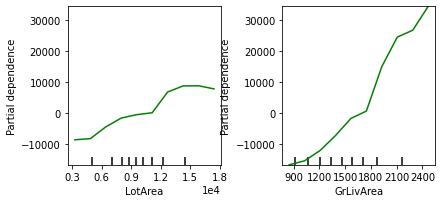

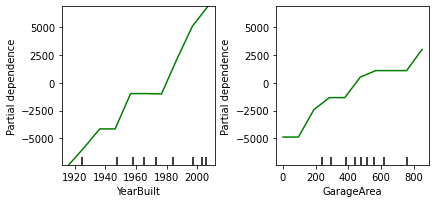

In [27]:
# We need to load a gradient booster that is compatible with scikit-learn's partial dependence module (not XGBoost).
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

my_model = GradientBoostingRegressor()
my_model.fit(X_train, y_train)
my_plots = plot_partial_dependence(my_model,       
                                   features=[X_train.columns.get_loc("LotArea"), X_train.columns.get_loc("GrLivArea")], # column numbers of plots we want to show
                                   X=X_train,            # raw predictors data.
                                   feature_names=list(X_train.columns.values), # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis
my_plots = plot_partial_dependence(my_model,       
                                   features=[X_train.columns.get_loc("YearBuilt"), X_train.columns.get_loc("GarageArea")], # column numbers of plots we want to show
                                   X=X_train,            # raw predictors data.
                                   feature_names=list(X_train.columns.values), # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

As expected, prices grow with larger available space (lot area, ground floor living area, garage) and more recent year built.

In [28]:
#!pip install scikit-learn==0.22.2 --user